# Dependencies

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from PIL import Image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Custom Dataset

In [2]:
class SimpleVeinDataset(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir):
        """
        Args:
            csv_file (str): Path to CSV with BatID and ImageID columns
            image_dir (str): Path to image folder
            mask_dir (str): Path to mask folder
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image ID
        image_id = self.data.iloc[idx]['ImageID']
        
        # Load image and mask
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        mask_path = os.path.join(self.mask_dir, f"{image_id}.jpg")
        
        # Open and convert to grayscale
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        # Convert to tensor and normalize
        image = torch.from_numpy(np.array(image)).float() / 255.0
        mask = torch.from_numpy(np.array(mask)).float() / 255.0
        
        # Add channel dimension
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return image, mask

# Data Loading

In [3]:
# Create dataset
dataset = SimpleVeinDataset(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset/Masks'
)

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=2, 
    shuffle=True  
)

# Validating Dataset

In [4]:
def group_and_display_all_bat_images(csv_file, image_dir, mask_dir):
    """
    Group and display all images from all bats
    
    Args:
        csv_file (str): Path to CSV with BatID and ImageID columns
        image_dir (str): Path to image folder
        mask_dir (str): Path to mask folder
    """
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Group by BatID
    grouped = df.groupby('BatID')
    
    # Create dataset for loading images
    dataset = SimpleVeinDataset(csv_file, image_dir, mask_dir)
    
    # Get all bat IDs
    all_bats = list(grouped.groups.keys())
    
    for bat_id in all_bats:
        # Get all image IDs for this bat
        bat_images = grouped.get_group(bat_id)
        num_images = len(bat_images)
        
        # Create a figure with enough subplots for all images and masks
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))
        plt.suptitle(f'Bat ID: {bat_id}', fontsize=16)
        
        # If there's only one image, wrap axes in list
        if num_images == 1:
            axes = axes.reshape(1, -1)
        
        # Load and display each image for this bat
        for idx, (_, row) in enumerate(bat_images.iterrows()):
            # Find index in dataset
            dataset_idx = df[df['ImageID'] == row['ImageID']].index[0]
            image, mask = dataset[dataset_idx]
            
            # Display image
            axes[idx, 0].imshow(image.squeeze(), cmap='gray')
            axes[idx, 0].set_title(f'Image {row["ImageID"]}')
            axes[idx, 0].axis('off')
            
            # Display mask
            axes[idx, 1].imshow(mask.squeeze(), cmap='gray')
            axes[idx, 1].set_title(f'Mask {row["ImageID"]}')
            axes[idx, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
"""
group_and_display_all_bat_images(
    csv_file='your_data.csv',
    image_dir='path/to/Images',
    mask_dir='path/to/Masks'
)
"""

def analyze_bat_distribution(csv_file):
    """
    Analyze the distribution of images across bats
    
    Args:
        csv_file (str): Path to CSV with BatId and ImageID columns
    """
    df = pd.read_csv(csv_file)
    grouped = df.groupby('BatID')
    
    # Get distribution statistics
    image_counts = grouped.size()
    
    print("\nBat Image Distribution:")
    print(f"Total number of bats: {len(image_counts)}")
    print(f"Total number of images: {len(df)}")
    print(f"Average images per bat: {image_counts.mean():.2f}")
    print(f"Min images per bat: {image_counts.min()}")
    print(f"Max images per bat: {image_counts.max()}")
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist(image_counts, bins='auto')
    plt.title('Distribution of Images per Bat')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Bats')
    plt.show()
    
    # Display counts for each bat
    print("\nDetailed image counts per bat:")
    for bat_id, count in image_counts.items():
        print(f"Bat {bat_id}: {count} images")

"""
**Uncomment this to view all the wing images for each bat!**
group_and_display_all_bat_images(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset/Masks'
)
"""

"\n**Uncomment this to view all the wing images for each bat!**\ngroup_and_display_all_bat_images(\n    csv_file='../Dataset/dataset.csv',\n    image_dir='../Dataset/Images',\n    mask_dir='../Dataset/Masks'\n)\n"

# Train/Test/Val Split


Dataset Split Information:
Total number of bats: 46
Number of training bats: 30
Number of validation bats: 6
Number of test bats: 10

Total number of images: 70
Number of training images: 51
Number of validation images: 8
Number of test images: 11

Displaying training samples:


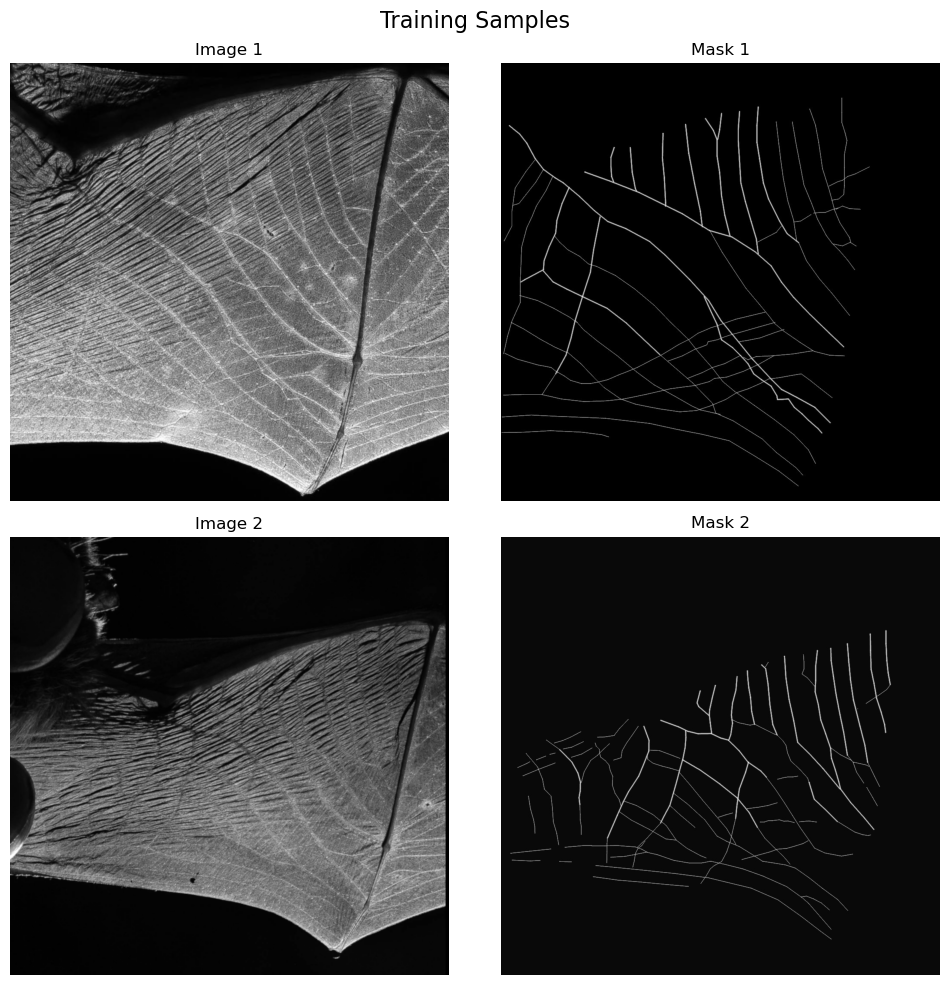


Displaying validation samples:


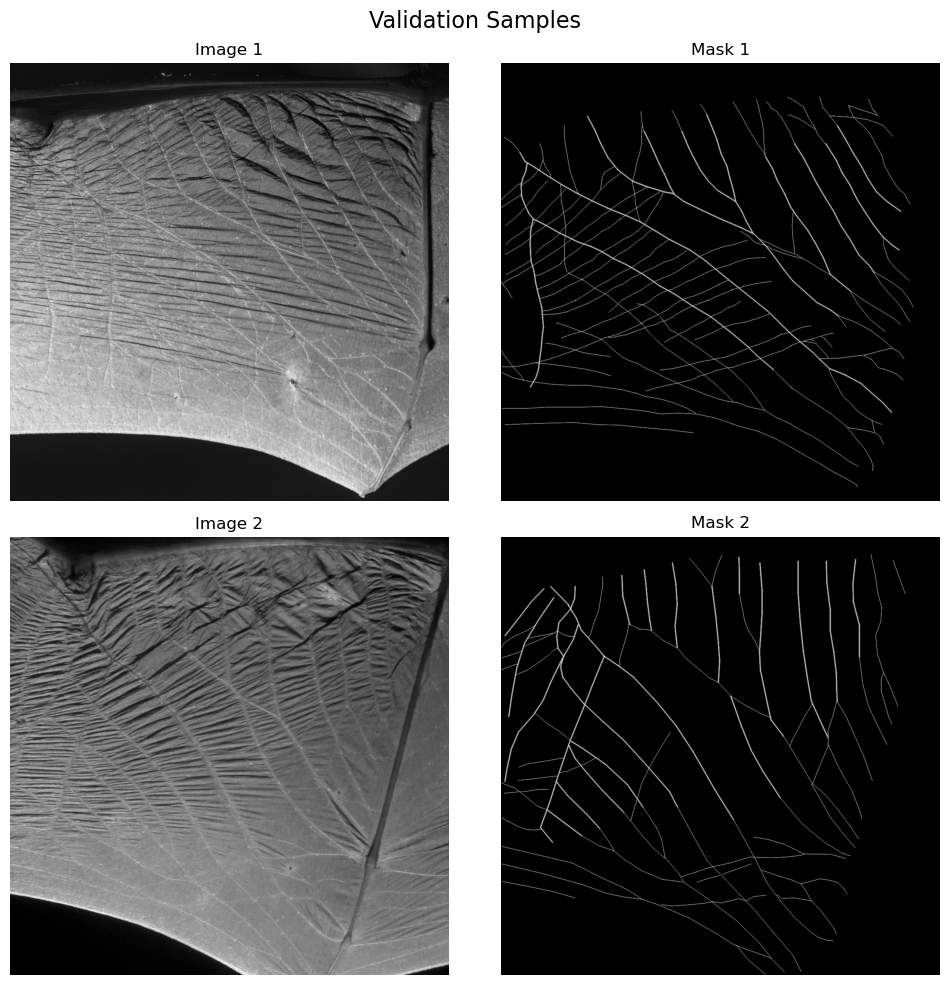


Displaying test samples:


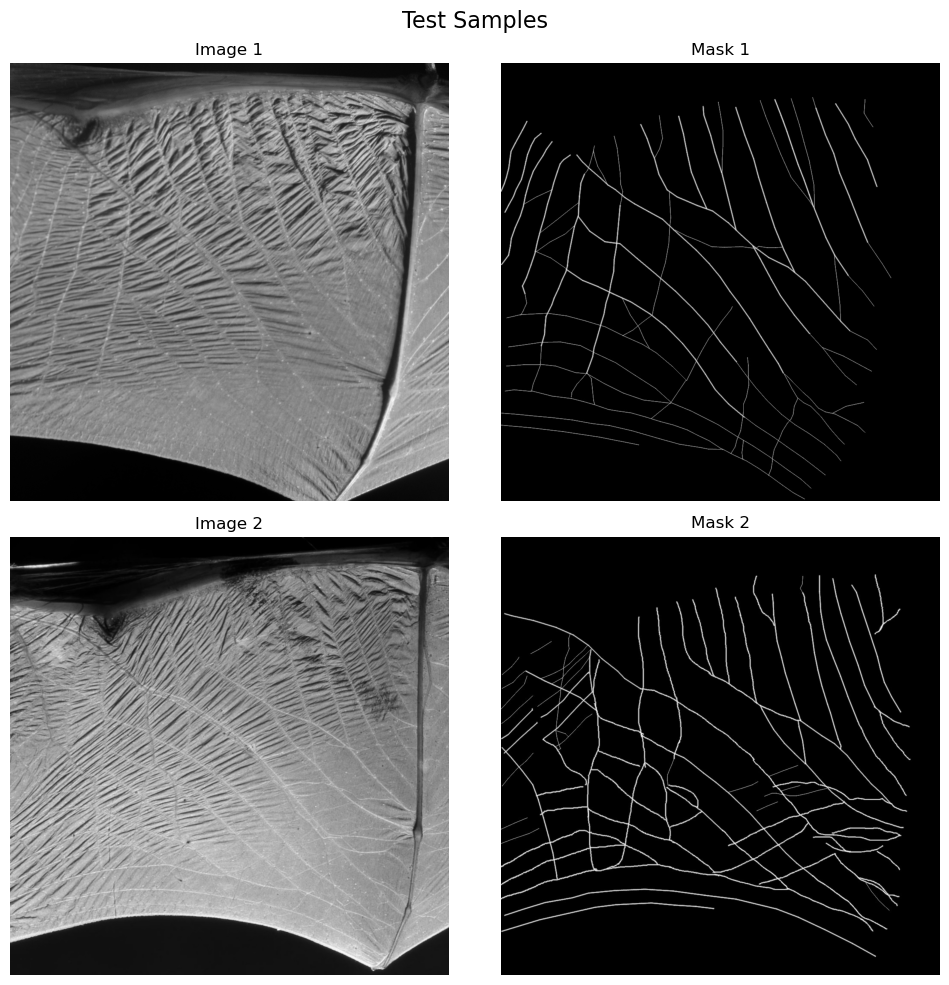

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

def create_train_val_test_splits(csv_file, image_dir, mask_dir, test_size=0.15, val_size=0.15, batch_size=1, random_state=420):
    """
    Create train, validation and test splits while keeping all images from the same bat together
    
    Args:
        csv_file (str): Path to CSV with BatID and ImageID columns
        image_dir (str): Path to image folder
        mask_dir (str): Path to mask folder
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of training data to use for validation
        batch_size (int): Batch size for dataloaders
        random_state (int): Random seed for reproducibility
    """
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Get unique bat IDs
    unique_bats = df['BatID'].unique()
    
    # First split off the test set
    train_val_bats, test_bats = train_test_split(
        unique_bats, 
        test_size=test_size,
        random_state=random_state
    )
    
    # Then split the remaining data into train and validation
    train_bats, val_bats = train_test_split(
        train_val_bats,
        test_size=val_size,
        random_state=random_state
    )
    
    # Create full dataset
    full_dataset = SimpleVeinDataset(csv_file, image_dir, mask_dir)
    
    # Get indices for each split
    train_indices = df[df['BatID'].isin(train_bats)].index.tolist()
    val_indices = df[df['BatID'].isin(val_bats)].index.tolist()
    test_indices = df[df['BatID'].isin(test_bats)].index.tolist()
    
    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )
    
    # Print split information
    print("\nDataset Split Information:")
    print(f"Total number of bats: {len(unique_bats)}")
    print(f"Number of training bats: {len(train_bats)}")
    print(f"Number of validation bats: {len(val_bats)}")
    print(f"Number of test bats: {len(test_bats)}")
    print(f"\nTotal number of images: {len(df)}")
    print(f"Number of training images: {len(train_indices)}")
    print(f"Number of validation images: {len(val_indices)}")
    print(f"Number of test images: {len(test_indices)}")
    
    return train_loader, val_loader, test_loader

def verify_data_splits(train_loader, val_loader, test_loader, num_samples=2):
    """
    Verify the splits by displaying some samples from each split
    """
    def show_batch(loader, title):
        # Get a batch
        images, masks = next(iter(loader))
        
        # Display up to num_samples from the batch
        n = min(num_samples, len(images))
        fig, axes = plt.subplots(n, 2, figsize=(10, 5*n))
        if n == 1:  # Handle case where there's only one sample
            axes = axes.reshape(1, -1)
        plt.suptitle(title, fontsize=16)
        
        for i in range(n):
            # Display image
            axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
            axes[i, 0].set_title(f'Image {i+1}')
            axes[i, 0].axis('off')
            
            # Display mask
            axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
            axes[i, 1].set_title(f'Mask {i+1}')
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Show samples from all splits
    print("\nDisplaying training samples:")
    show_batch(train_loader, "Training Samples")
    
    print("\nDisplaying validation samples:")
    show_batch(val_loader, "Validation Samples")
    
    print("\nDisplaying test samples:")
    show_batch(test_loader, "Test Samples")



# Create the splits
train_loader, val_loader, test_loader  = create_train_val_test_splits(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset//Masks',
    test_size=0.2,
    batch_size=2
)

# Verify the splits
verify_data_splits(train_loader, val_loader, test_loader)

# Initialize Model

In [6]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """
    Double Convolution block:
    (Conv2d -> BatchNorm -> ReLU) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        """
        Standard U-Net architecture
        Args:
            in_channels (int): Number of input channels (1 for grayscale, 3 for RGB)
            out_channels (int): Number of output channels (1 for binary segmentation)
            features (list): Feature dimensions for each level
        """
        super().__init__()
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling/Encoder path
        in_feat = in_channels
        for feature in features:
            self.downs.append(DoubleConv(in_feat, feature))
            in_feat = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling/Decoder path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Optional sigmoid for binary segmentation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Store skip connections
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections list for easier access
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Upsample
            skip = skip_connections[idx//2]

            # Handle cases where input dimensions aren't perfectly divisible by 2
            #if x.shape != skip.shape:
                #x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)

            # Concatenate with skip connection
            concat_skip = torch.cat((skip, x), dim=1)
            
            # Double convolution
            x = self.ups[idx+1](concat_skip)

        # Final 1x1 convolution and sigmoid
        return self.sigmoid(self.final_conv(x))

# Example usage:

# Initialize model
model = UNet(
    in_channels=1,  # 1 for grayscale
    out_channels=1, # 1 for binary segmentation
    features=[32, 64, 128, 256, 512]  # Feature dimensions at each level
)

# Loss, Optimizer and Device

In [7]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
        
    def forward(self, predictions, targets):
        dice_loss = self.dice(predictions, targets)
        bce_loss = self.bce(predictions, targets)
        
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

def setup_training(model, learning_rate=1e-4, loss_type='combined'):
    """
    Set up loss function and optimizer for training
    
    Args:
        model: The U-Net model
        learning_rate: Learning rate for the optimizer
        loss_type: One of 'bce', 'dice', or 'combined'
        
    Returns:
        criterion: Loss function
        optimizer: Optimizer
    """
    # Set up loss function
    if loss_type == 'bce':
        criterion = nn.BCELoss()
    elif loss_type == 'dice':
        criterion = DiceLoss()
    elif loss_type == 'combined':
        criterion = CombinedLoss(dice_weight=0.5, bce_weight=0.5)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")
    
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Optional: Set up learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    
    return criterion, optimizer, scheduler


# Setup with combined loss
criterion, optimizer, scheduler = setup_training(
    model,
    learning_rate=0.001,
    loss_type='combined'
)

c:\Users\Robby\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training Loop

In [9]:
def train_model(model, 
                train_loader, 
                val_loader, 
                criterion, 
                optimizer, 
                scheduler, 
                num_epochs, 
                device,
                save_path='best_model.pth'):
    """
    Training loop for U-Net model with improved progress tracking
    """
    # Initialize best validation loss
    best_val_loss = float('inf')
    
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    
    print(f"Starting training at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    
    # Main epoch loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_dice = 0
        batch_count = 0
        
        print("Training...")
        for images, masks in train_loader:
            # Move data to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(images)
            
            # Calculate loss
            loss = criterion(predictions, masks)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            batch_count += 1
            
            # Print progress
            if batch_count % 1 == 0:  # Print every batch
                print(f"Batch {batch_count}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Calculate average training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        batch_count = 0
        
        print("\nValidating...")
        with torch.no_grad():
            for images, masks in val_loader:
                # Move data to device
                images = images.to(device)
                masks = masks.to(device)
                
                # Forward pass
                predictions = model(images)
                
                # Calculate loss
                loss = criterion(predictions, masks)
                
                # Update metrics
                val_loss += loss.item()
                batch_count += 1
                
                # Print progress
                if batch_count % 1 == 0:  # Print every batch
                    print(f"Batch {batch_count}/{len(val_loader)}, Loss: {loss.item():.4f}")
        
        # Calculate average validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate scheduler
        scheduler.step(avg_val_loss)
        
        # Print epoch summary
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
            }, save_path)
            print(f'Saved new best model with validation loss: {avg_val_loss:.4f}')
        
        # Plot current progress
        if (epoch + 1) % 5 == 0:  # Plot every 5 epochs
            plot_training_history(train_losses, val_losses)

    
    # Final plot
    plot_training_history(train_losses, val_losses)
    
    return train_losses, val_losses

def plot_training_history(train_losses, val_losses):
    """Plot training and validation loss history"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    device=device
)

# Testing

In [ ]:
def predict_and_visualize(model, test_loader, device, num_examples=5):
    """
    Make predictions on test data and visualize the results
    """
    model.eval()  # Set model to evaluation mode
    
    # Get the underlying dataset from the test_loader
    test_dataset = test_loader.dataset

    # Shuffle the dataset
    test_dataset.dataset.df = test_dataset.dataset.df.sample(frac=1).reset_index(drop=True)


    with torch.no_grad():  # No need to track gradients
        for i in range(min(num_examples, len(test_dataset))):
            # Get a single example directly from the dataset
            image, true_mask = test_dataset[i]
            
            # Add batch dimension
            image = image.unsqueeze(0)
            true_mask = true_mask.unsqueeze(0)
            
            # Move to device
            image = image.to(device)
            true_mask = true_mask.to(device)
            
            # Make prediction
            prediction = model(image)
            
            # Move everything back to CPU for visualization
            image = image.cpu()
            true_mask = true_mask.cpu()
            prediction = prediction.cpu()
            
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title('Original Image')
            plt.axis('off')
            
            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask.squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def load_model_and_predict(model_path, test_loader, device, num_examples=5):
    """
    Load a saved model and make predictions
    """
    # Initialize model
    model = UNet(in_channels=1, out_channels=1).to(device)
    
    # Load saved weights
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Make predictions
    predict_and_visualize(model, test_loader, device, num_examples)

In [ ]:
predict_and_visualize(model, test_loader, device, num_examples=5)

In [ ]:
load_model_and_predict('best_model.pth', test_loader, device)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def create_interactive_viewer(model, test_loader, device):
    """
    Creates an interactive viewer with sliders for opacity and image selection
    """
    # Get the test dataset
    test_dataset = test_loader.dataset
    
    def view_prediction(image_idx, overlay_opacity, mask_threshold):
        """
        Display prediction with adjustable opacity and threshold
        """
        model.eval()
        with torch.no_grad():
            # Get image and true mask
            image, true_mask = test_dataset[image_idx]
            
            # Add batch dimension and predict
            image_batch = image.unsqueeze(0).to(device)
            prediction = model(image_batch).cpu().squeeze()
            
            # Create figure
            plt.figure(figsize=(15, 5))
            
            # Original with overlay
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            
            # Create masked prediction for overlay
            prediction_binary = (prediction > mask_threshold).float()
            prediction_rgba = np.zeros((*prediction.shape, 4))
            prediction_rgba[..., 0] = 1  # Red channel
            prediction_rgba[..., 3] = prediction_binary * overlay_opacity  # Alpha channel
            
            plt.imshow(prediction_rgba, alpha=overlay_opacity)
            plt.title('Original + Prediction Overlay')
            plt.axis('off')
            
            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask.squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Raw prediction
            plt.subplot(1, 3, 3)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title('Raw Prediction')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Create interactive widget
    interact(
        view_prediction,
        image_idx=IntSlider(
            min=0,
            max=len(test_dataset)-1,
            step=1,
            value=0,
            description='Image:'
        ),
        overlay_opacity=FloatSlider(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description='Opacity:'
        ),
        mask_threshold=FloatSlider(
            min=0,
            max=1,
            step=0.05,
            value=0.5,
            description='Threshold:'
        )
    )

# Alternative version with different color options
def create_interactive_viewer_with_colors(model, test_loader, device):
    """
    Creates an interactive viewer with sliders for opacity, threshold, and color selection
    """
    test_dataset = test_loader.dataset
    
    # Define color options
    color_options = {
        'Red': [1, 0, 0],
        'Green': [0, 1, 0],
        'Blue': [0, 0, 1],
        'Yellow': [1, 1, 0],
        'Magenta': [1, 0, 1],
        'Cyan': [0, 1, 1]
    }
    
    def view_prediction(image_idx, overlay_opacity, mask_threshold, overlay_color):
        model.eval()
        with torch.no_grad():
            # Get image and predict
            image, true_mask = test_dataset[image_idx]
            image_batch = image.unsqueeze(0).to(device)
            prediction = model(image_batch).cpu().squeeze()
            
            plt.figure(figsize=(15, 5))
            
            # Original with colored overlay
            plt.subplot(1, 3, 1)
            plt.imshow(image.squeeze(), cmap='gray')
            
            # Create colored overlay
            prediction_binary = (prediction > mask_threshold).float()
            prediction_rgba = np.zeros((*prediction.shape, 4))
            color = color_options[overlay_color]
            prediction_rgba[..., 0] = color[0]  # R
            prediction_rgba[..., 1] = color[1]  # G
            prediction_rgba[..., 2] = color[2]  # B
            prediction_rgba[..., 3] = prediction_binary * overlay_opacity  # Alpha
            
            plt.imshow(prediction_rgba)
            plt.title('Original + Colored Prediction')
            plt.axis('off')
            
            # True mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask.squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Raw prediction
            plt.subplot(1, 3, 3)
            plt.imshow(prediction.squeeze(), cmap='gray')
            plt.title('Raw Prediction')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    # Create interactive widget with color selection
    interact(
        view_prediction,
        image_idx=IntSlider(
            min=0,
            max=len(test_dataset)-1,
            step=1,
            value=0,
            description='Image:'
        ),
        overlay_opacity=FloatSlider(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description='Opacity:'
        ),
        mask_threshold=FloatSlider(
            min=0,
            max=1,
            step=0.05,
            value=0.5,
            description='Threshold:'
        ),
        overlay_color=widgets.Dropdown(
            options=list(color_options.keys()),
            value='Red',
            description='Color:'
        )
    )

# Usage:
"""
# Basic version with red overlay:
create_interactive_viewer(model, test_loader, device)

# Version with color selection:
create_interactive_viewer_with_colors(model, test_loader, device)
"""

# Initialize model
model = UNet(in_channels=1, out_channels=1).to(device)

# Load saved weights
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

create_interactive_viewer(model, test_loader, device)


C:\Users\Robby\AppData\Local\Temp\ipykernel_36480\3402083933.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


interactive(children=(IntSlider(value=0, description='Image:', max=10), FloatSlider(value=0.5, description='Op…